# Conditional Mixture Models
## Logistic Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from numpy.linalg import inv
from numpy.random import multivariate_normal, rand, randn, seed

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

Consider $K$ logistic regression models ($f_k: \mathbb{R}^M\to[0,1]$), each governed by its own weight vector ${\bf w}_k$. To make a **mixture of logistic regressions**, we consider a set of weighting coefficients $\{\pi_k\}_k$ and a mixture distribution given by

$$
\begin{aligned}
    p({\bf t}\vert \boldsymbol\theta,\boldsymbol\phi) &= \sum_{k=1}^K \pi_k \text{Bern}\big(t_n\vert\sigma\left({\bf w}_k^T\boldsymbol\phi_n\right)\big)\\
    &= \sum_{k=1}^K \pi_k \sigma\left({\bf w}_k^T\boldsymbol\phi_n\right)^{t_n}\left(1 -  \sigma\left({\bf w}_k^T\boldsymbol\phi_n\right)\right)^{1-t_n}\\
\end{aligned}
$$

Where $\boldsymbol\theta=\big\{\{{\bf w}_k\}_k, \{\pi_k\}_k\big\}$

In order to find the values of $\boldsymbol\theta$, we make use of th EM algorithm by introducing latent variables ${\bf Z}=\{{\bf z}_n\}_n$. The EM algorithm then turns in finding the coefficients

$$
\gamma_{nk} = \frac{\pi_k\text{Bern}\big(t_n\vert\sigma\left({\bf w}_k^T\boldsymbol\phi_n\right)\big)}{\sum_j\pi_j\text{Bern}\big(t_n\vert\sigma\left({\bf w}_j^T\boldsymbol\phi_n\right)\big)}
$$

for the **E-step**, and maximizing

$$
Q(\boldsymbol\theta, \boldsymbol\theta^{\text{old}}) = \sum_{n=1}^N\sum_{k=1}^K \gamma_{nk}\big[\log\pi_k +  t_n\log\sigma\left({\bf w}^T_k\boldsymbol\phi_n\right) + (1 - t_n)\log\left(1 - \sigma\left({\bf w}^T_k\boldsymbol\phi_n\right)\right)\big]
$$

w.r.t. each component of $\boldsymbol\theta$ for the **M-step**.

The M-step results updating the equations:

$$
\pi_k^\text{new} = \frac{1}{N}\sum_{n=1}^N\gamma_{nk}
$$

And updating ${\bf w}_k$ using the IRLS algorithm (see chapter4) as:

$$
    {\bf w}_k := {\bf w}_k - {\bf H}^{-1}\nabla {\mathcal L}_{{\bf k}_k}({\bf w})
$$

With

$$
\nabla {\mathcal L}_{{\bf k}_k}({\bf w}) = \sum_{n=1}^N\gamma_{nk}\left[t_n - \sigma\left({\bf w}^T_k\boldsymbol\phi_n\right)\right]\boldsymbol\phi_n
$$

$$
{\bf H} = -\sum_{n=1}^N \sigma\left({\bf w}^T_k\boldsymbol\phi_n\right)\left[1 - \sigma\left({\bf w}^T_k\boldsymbol\phi_n\right)\right]\boldsymbol\phi_n\boldsymbol\phi_n^T
$$

In [3]:
seed(314)
mus = np.array([
    [0, -2],
    [-2, 0],
    [0, 2],
    [2, 0]
])
cat = np.array([0, 1, 0, 1])

sigma = 0.5
n_samples = 100
X = []
t = []

for mu, c in zip(mus, cat):
    X_sample = multivariate_normal(mean=mu, cov=np.eye(2) * sigma, size=n_samples)
    y_sample = np.ones(n_samples) * c
    
    X.append(X_sample)
    t.append(y_sample)

X = np.concatenate(X)
t = np.concatenate(t)

D = np.c_[X, t]
np.random.shuffle(D)

X, t = D[:, :2], D[:, -1]
N, M = X.shape

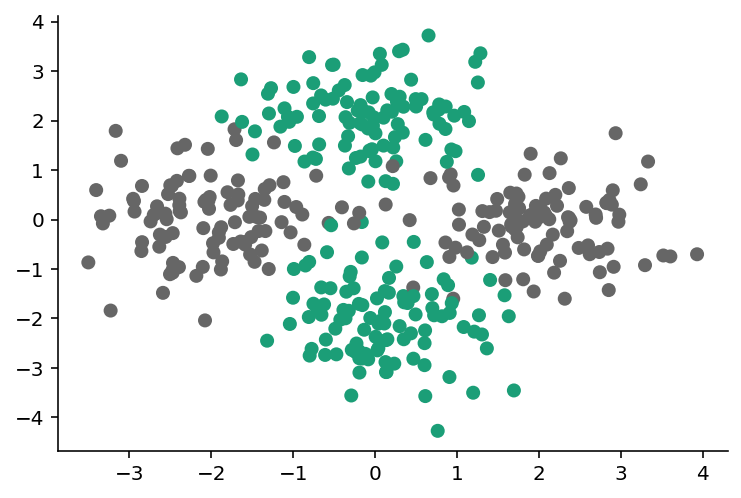

In [4]:
plt.scatter(*X.T, c=t, cmap="Dark2", facecolors="none")

In [5]:
phi = np.c_[np.ones(N), X]
N, M = phi.shape

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

## First Iteration

In [7]:
# parameter initializiation
seed(314)
# MxK
w_em = randn(M, 2)
pi_em = rand(2)
pi_em = pi_em / pi_em.sum()
# auxiliary latent vector: NxK
z_em = np.ones((N, 2))

In [8]:
p_nk = sigmoid(np.einsum("nm,mk->nk", phi, w_em))
Bern_vals_nk = bernoulli(p=p_nk).pmf(t[:, None])
gamma_nk = Bern_vals_nk / Bern_vals_nk.sum(axis=1, keepdims=True)

In [9]:
# Pi update
pi_em = gamma_nk.mean(axis=0)
pi_em

array([0.49166442, 0.50833558])

In [10]:
# w update
grad_Lw = np.einsum("nk,nm->mk", gamma_nk * (t[:, None] - p_nk), phi)
H_neg = inv(np.einsum("nk,nm,nl->kml", p_nk * (1 - p_nk), phi, phi))
w_em = w_em + np.einsum("kml,lk->mk", H_neg, grad_Lw)

w_em

array([[ 0.07605521,  0.75302051],
       [ 0.7821679 , -0.60002564],
       [-0.97233062,  1.07896135]])

## All together

In [11]:
def e_step(phi, t, w):
    p_nk = sigmoid(np.einsum("nm,mk->nk", phi, w))
    Bern_vals_nk = bernoulli(p=p_nk).pmf(t[:, None])
    gamma_nk = Bern_vals_nk / Bern_vals_nk.sum(axis=1, keepdims=True)
    return gamma_nk

def m_step(phi, t, w, gamma_nk):
    p_nk = sigmoid(np.einsum("nm,mk->nk", phi, w))
    # Pi update
    pi = gamma_nk.mean(axis=0)
    # w update
    grad_Lw = np.einsum("nk,nm->mk", gamma_nk * (t[:, None] - p_nk), phi)
    H_neg = inv(np.einsum("nk,nm,nl->kml", p_nk * (1 - p_nk), phi, phi))
    w = w + np.einsum("kml,lk->mk", H_neg, grad_Lw)
    
    return pi, w

In [12]:
# parameter initializiation
seed(31)
# MxK
w_em = randn(M, 2)
pi_em = rand(2)
pi_em = pi_em / pi_em.sum()
# auxiliary latent vector: NxK
z_em = np.ones((N, 2))

In [13]:
for _ in range(35):
    gamma_nk = e_step(phi, t, w_em)
    pi_em, w_em = m_step(phi, t, w_em, gamma_nk)

In [14]:
xmin, xmax = X[:, 0].min(), X[:, 0].max()
ymin, ymax = X[:, 1].min(), X[:, 1].max()

p_grid = np.mgrid[xmin:xmax*1.1:0.05, ymin:ymax*1.1:0.05]
_, S1, S2 = p_grid.shape
phi_grid = np.concatenate([np.ones((1, S1, S2)), p_grid], axis=0)

In [15]:
p_kso = sigmoid(np.einsum("mso,mk->kso", phi_grid, w_em))
p_so = np.einsum("k,kso->so", pi_em, p_kso)

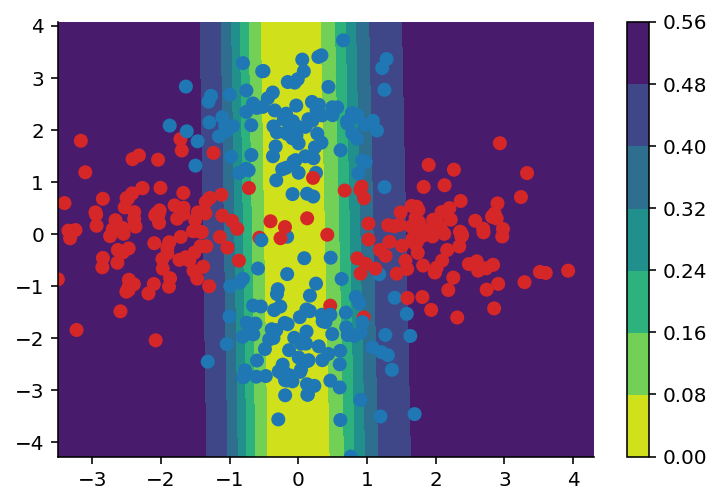

In [16]:
plt.contourf(*p_grid, p_so, cmap="viridis_r")
plt.colorbar()

colors = ["tab:red" if ti == 1 else "tab:blue" for ti in t]
plt.scatter(*X.T, c=colors);